# Toronto Neighborhood/Borough Analysis

This notebook corresponds to the peer reviewed project of Applied DS Capstone Project.

The task consist to retrieve the data of Toronto's neighborhoods via scrapping from Wikipedia, explore, clean and preprocess it to then apply a clustering model to group similar neighborhoods.

First, we need to import the main packages:

In [1]:
import pandas as pd
import numpy as np

## Part 1: Getting the data of Toronto Boroughs and Neighborhoods

### a) Web-scrapping the Wikipedia table with Beautiful Soup 4

We install and import the Beautiful Soup 4 package to get the HTML tags as text and the _requests_ to get the whole HTML page using a GET request:

In [2]:
# Uncomment if the package is not installed
# pip install beautifulsoup4

In [3]:
from bs4 import BeautifulSoup
import requests

We proceed to make a GET request to retrieve the page and then parse it to a _BeautifulSoup_ object.

In [4]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source, "lxml")
soup.title

<title>List of postal codes of Canada: M - Wikipedia</title>

Now that we have the whole HTML code of the page, lets build a pandas DF from the table.

Having explored the body component of the web page, we notice:
- The columns's names are the **th** tags of the first **tr** group of the _table_ component.
- The rows of the table with the values are in a **tr** per row starting from second, and a **td** object for each attribute of the row.

In [5]:
# We create an array with the columns' names to then create the DF
headers = []
rows = []
first_row = True
for group in soup.table.find_all('tr'):
    # Using split()[0] because last item of each row had \n in it
    if first_row:
        headers = [header.text.split('\n')[0] for header in group.find_all('th')]
        first_row = False
    else:
        row = [value.text.split('\n')[0] for value in group.find_all('td')]
        rows.append(row)
print('Headers: ',headers)
print('First 5 rows: ',rows[:6])

Headers:  ['Postcode', 'Borough', 'Neighbourhood']
First 5 rows:  [['M1A', 'Not assigned', 'Not assigned'], ['M2A', 'Not assigned', 'Not assigned'], ['M3A', 'North York', 'Parkwoods'], ['M4A', 'North York', 'Victoria Village'], ['M5A', 'Downtown Toronto', 'Harbourfront'], ['M5A', 'Downtown Toronto', 'Regent Park']]


Now that we have the columns's headers and the values in two different lists, we can proceed to create the DF:

In [6]:
df = pd.DataFrame(data=rows, columns=headers)
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [7]:
df.shape

(288, 3)

### b) Cleaning the dataset to meet instructions criteria

We have the DF with all the values of the table. Now we have to clean those values to meet the criteria stated in the task instructions. We will do them one by one.

**Criteria: Only process the cells that have an assigned _borough_. Ignore cells with a borough that is _Not assigned_.**

In [8]:
# Replace all 'Not assigned' with NaN values to simplify the cleaning
df.replace('Not assigned', np.NaN, inplace=True)

# Select only not-null values of 'Borough'
df = df[pd.notnull(df['Borough'])]
df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


We verify the criteria is met by looking the new number of rows (last one was 288) and if there's any NaN value in Borough: 

In [9]:
print('New shape: ', df.shape)
print('Any NaN value in Borough: ', df['Borough'].isnull().any())

New shape:  (211, 3)
Any NaN value in Borough:  False


**Criteria: If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.**

In [10]:
df[pd.isnull(df['Neighbourhood'])]

,Postcode,Borough,Neighbourhood
8,M7A,Queen's Park,NaN


As we only have one value to fix, we can do it manually:

In [11]:
df['Neighbourhood'].replace(np.NaN, "Queen's Park", inplace=True)

We verify there's no NaN value left in Neighbourhood:

In [12]:
print('Any NaN value in Neighbourhood: ', df['Neighbourhood'].isnull().any())

Any NaN value in Neighbourhood:  False


**Criteria: More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.**

In [13]:
df = df.groupby(['Postcode','Borough']).Neighbourhood.apply(lambda x: ', '.join(x)).to_frame()
df.reset_index(inplace=True)
df.head(10)

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


Having done that, lets see what is the shape of our final DF:

In [14]:
print('Grouped DF shape: ', df.shape)

Grouped DF shape:  (103, 3)


Now we have the DF cleaned, we can proceed to get the geographical information for each neighborhood.

## Part 2: Getting coordinates for each postal code

As said in the instructions, we will use the Geocoder package, so let's import it:

In [15]:
# Uncomment if geocoder is not installed
# !pip install geocoder

In [16]:
# Had to disable this, never returned any result and the kernel crashed, I will try to fix it later
# but for now I'll be using the CSV provided in the instructions
'''
import geocoder

latitudes = longitudes = []

for postal_code in df['Postcode']:
    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
      geo = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
      lat_lng_coords = geo.latlng

    print(lat_lng_coords)
    latitudes.append(lat_lng_coords[0])
    longitudes.append(lat_lng_coords[1])

print('First 5 coordinates: ',[zip(latitudes.head(), longitudes.head())])

df['Latitude'] = pd.Series(latitudes)
df['Longitude'] = pd.Series(longitudes)
df.head(10)
'''

"\nimport geocoder\n\nlatitudes = longitudes = []\n\nfor postal_code in df['Postcode']:\n    # initialize your variable to None\n    lat_lng_coords = None\n\n    # loop until you get the coordinates\n    while(lat_lng_coords is None):\n      geo = geocoder.google('{}, Toronto, Ontario'.format(postal_code))\n      lat_lng_coords = geo.latlng\n\n    print(lat_lng_coords)\n    latitudes.append(lat_lng_coords[0])\n    longitudes.append(lat_lng_coords[1])\n\nprint('First 5 coordinates: ',[zip(latitudes.head(), longitudes.head())])\n\ndf['Latitude'] = pd.Series(latitudes)\ndf['Longitude'] = pd.Series(longitudes)\ndf.head(10)\n"

In [17]:
# Temporary way of getting the coordinates through provided CSV

coordinates = pd.read_csv('http://cocl.us/Geospatial_data')
coordinates.shape

(103, 3)

For practical reasons, we will modify the columns' names to match the column 'PostalCode':

In [18]:
print('Actual data columns names: ', df.columns)
print('Actual coordinates names: ', coordinates.columns)
df.columns = ['PostalCode', 'Borough', 'Neighborhood']
coordinates.columns = ['PostalCode', 'Latitude','Longitude']
print('Modified data columns names: ', df.columns)
print('Modified coordinates names: ', coordinates.columns)

Actual data columns names:  Index(['Postcode', 'Borough', 'Neighbourhood'], dtype='object')
Actual coordinates names:  Index(['Postal Code', 'Latitude', 'Longitude'], dtype='object')
Modified data columns names:  Index(['PostalCode', 'Borough', 'Neighborhood'], dtype='object')
Modified coordinates names:  Index(['PostalCode', 'Latitude', 'Longitude'], dtype='object')


Now we have the latitudes and longitudes, we can just merge them to the DF:

In [19]:
# First we ensure both DFs are ordered by Postal Code
df.sort_values('PostalCode', ascending=True, inplace=True)
coordinates.sort_values('PostalCode', ascending=True, inplace=True)

# Now we copy the Latitude and Longitude columns to DF:
df['Latitude'] = coordinates['Latitude']
df['Longitude'] = coordinates['Longitude']
df.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


And lastly, we verify our dataset is correct by looking up if there's a NaN value (due to the merging):

In [20]:
print('Any NaN value in DF:\n',df.isnull().any())

Any NaN value in DF:
 PostalCode      False
Borough         False
Neighborhood    False
Latitude        False
Longitude       False
dtype: bool


We may verify the **final shape** of the dataset:

In [21]:
print('Final shape of the dataset: ', df.shape)

Final shape of the dataset:  (103, 5)


## Part 3: Exploration and Clustering of the data

### a) Exploring and visualizing the boroughs

To explore the data, we will follow the next steps:
- Get the Toronto city coordinates using __Geopy__.
- Visualize a map with the Toronto boroughs pointed out as markers in it using __Folium__.

For this task, we will need the following packages:

In [22]:
# Uncomment this if Geopy is not installed
#!pip install geopy
from geopy.geocoders import Nominatim

In [23]:
# Uncomment this if Folium is not installed
#!pip install folium
import folium

We get the coordinates of the Toronto city using _Nominatim_ module:

In [25]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent='toronto_exploration')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'
      .format(latitude, longitude))

The geograpical coordinates of Toronto are 43.653963, -79.387207.


Now we proceed to use Folium library to create a map centered in Toronto and displaying each neighborhood as a marker:

In [26]:
# Create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# Add boroughs as markers
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#ff6464',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### **Important note: Problem and procedure aclaration**

Our dataset, as displayed in the map, has 103 unique _Postal Codes_, a total of 11 distinct boroughs and each one may be part of one or more Postal Codes with many neighborhoods inside of each one:

In [36]:
print('Unique boroughs: ', len(df['Borough'].unique()))

Unique boroughs:  11


As the dataset is built mainly with the coordinates for each _Postal Code_, and not for neighborhoods, we will simplify the analysis by exploring venues near groups of neighborhoods belonging to the same Postal Code and performing clustering directly with them, instead of individual neighborhoods.

So, more explicitly, the problem to be analysed will consist by the following:

**Using some groups of Toronto neighborhoods belonging to the same Postal Codes (explicitly the ones having a 'Toronto' in its Borough name, as an advise of the instructions), we will retrieve using Foursquare API, their most popular venues nearby in a 800 meter radius (a maximum of 100) to then cluster those groups based on the most common venues for each group of neighborhoods.**

Having explained that, we may proceed with the collection of data about venues using Foursquare API.

### b) Defining Foursquare Credentials, Version and some functions we'll need later

In [37]:
CLIENT_ID = 'QWB1D2VWCNHJN5BDM2ZY2VK4CYCEGUGOCNNBZBUF2R03EQ4T' # Foursquare ID
CLIENT_SECRET = 'JJRLC3BFXFBR1EBJLDJ22LEJKJBYC211RCTFGIWUCJ31TU2O' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

Credentials:
CLIENT_ID: QWB1D2VWCNHJN5BDM2ZY2VK4CYCEGUGOCNNBZBUF2R03EQ4T
CLIENT_SECRET: JJRLC3BFXFBR1EBJLDJ22LEJKJBYC211RCTFGIWUCJ31TU2O


So, we have defined the credentials. Next we will define some functions (based in NY notebook):

In [38]:
# Function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [56]:
# Function that gets 100 closest venues to a postal code coordinates
def getNearbyVenues(postal_codes, latitudes, longitudes, radius=800):
    
    LIMIT = 100
    venues_list=[]
    
    for code, lat, lng in zip(postal_codes, latitudes, longitudes):
        print('Querying venues from: ', code)
            
        # Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # Make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Return only relevant information for each nearby venue
        venues_list.append([(
            code, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code', 
                  'Neighborhood Group Latitude', 
                  'Neighborhood Group Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### c) Setting up the Neighborhood groups to be analysed and retrieving their closest venues

As we said earlier, we will only select Postal Codes which Boroughs contain the 'Toronto' word in their name.

So let's select those ones in a different DF:

In [95]:
codes_selected = df[df.Borough.str.contains('Toronto',case=False)]
print('Shape of selected Postal Codes DF: ', codes_selected.shape)
codes_selected.head()

Shape of selected Postal Codes DF:  (38, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


We have selected 38 groups of neighborhoods to analyse. Now we have to retrieve their 100 closest venues, by using the function that accomplishes that task:

In [59]:
# Uncomment this group of code if the data is not available
# in a local CSV file. Otherwise use the file
'''
all_venues = getNearbyVenues(postal_codes=codes_selected['PostalCode'],
                             latitudes=codes_selected['Latitude'],
                             longitudes=codes_selected['Longitude']
                            )
'''
# Getting the data from the written CSV file. Comment the next
# two lines if uncommenting the code group above
all_venues = pd.read_csv('all_venues_data.csv')
all_venues.drop('Unnamed: 0', inplace=True, axis=1)

print('Data shape: ', all_venues.shape)
all_venues.head()

Data shape:  (2712, 7)


,Postal Code,Neighborhood Group Latitude,Neighborhood Group Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M4E,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,M4E,43.676357,-79.293031,Tori's Bakeshop,43.672114,-79.290331,Vegetarian / Vegan Restaurant
2,M4E,43.676357,-79.293031,The Beech Tree,43.680493,-79.288846,Gastropub
3,M4E,43.676357,-79.293031,Ed's Real Scoop,43.672630,-79.287993,Ice Cream Shop
4,M4E,43.676357,-79.293031,The Fox Theatre,43.672801,-79.287272,Indie Movie Theater


The data retrieved sums up to 2702 venues for all 38 neighborhood groups. To not call the Foursquare API each time, we will write this result as a CSV file to make the data available without calling again the API:

In [62]:
# Uncomment this code if there was no CSV file with the venues data
# but it was retrieved by calling the API

# all_venues.to_csv('all_venues_data.csv')

We can count how many venues were returned for each neighborhood group:

In [60]:
all_venues.groupby('Postal Code').count()

,Neighborhood Group Latitude,Neighborhood Group Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Postal Code,,,,,,
M4E,48,48,48,48,48,48
M4K,100,100,100,100,100,100
M4L,53,53,53,53,53,53
M4M,97,97,97,97,97,97
M4N,7,7,7,7,7,7
M4P,55,55,55,55,55,55
M4R,34,34,34,34,34,34
M4S,82,82,82,82,82,82
M4T,14,14,14,14,14,14


Let's find out how many unique categories can be curated from all the returned venues:

In [61]:
print('There are {} unique categories.'.format(len(all_venues['Venue Category'].unique())))

There are 279 unique categories.


### d) Preprocessing the venues data

Next we are going to apply One-Hot Encoding to transform the dataset into the number of venues by category for each neighborhood group:

In [63]:
# Applying OH Encoding by 'creating dummies'
venues_one_hot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

# Add the 'Postal Code' column back to dataset
venues_one_hot['Postal Code'] = all_venues['Postal Code'] 

# Move postal code column to the first column
fixed_columns = [venues_one_hot.columns[-1]] + list(venues_one_hot.columns[:-1])
venues_one_hot = venues_one_hot[fixed_columns]

venues_one_hot.head()

,Postal Code,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Yoga Studio
0,M4E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M4E,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,M4E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M4E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M4E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by Postal code and by taking the mean of the frequency of occurrence of each category:

In [64]:
venues_grouped = venues_one_hot.groupby('Postal Code').mean().reset_index()
venues_grouped

,Postal Code,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Yoga Studio
0,M4E,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.020833,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
1,M4K,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,...,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.020000
2,M4L,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
3,M4M,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030928,...,0.00,0.00,0.000000,0.00,0.000000,0.020619,0.00,0.000000,0.000000,0.010309
4,M4N,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
5,M4P,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.018182,0.00,0.000000,0.000000,0.00,0.018182,0.000000,0.000000
6,M4R,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.029412
7,M4S,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.012195,0.00,0.000000,0.000000,0.00,0.000000,0.012195,0.012195
8,M4T,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
9,M4V,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015625,...,0.00,0.00,0.015625,0.00,0.000000,0.015625,0.00,0.000000,0.000000,0.015625


Now, let's explore what are the 5 more popular venue categories from each neighborhood group:

In [68]:
num_top_venues = 5

for code in venues_grouped['Postal Code']:
    print("------------ "+code+" ------------")
    temp = venues_grouped[venues_grouped['Postal Code'] == code].T.reset_index()
    temp.columns = ['Venue Cat','Freq']
    temp = temp.iloc[1:]
    temp['Freq'] = temp['Freq'].astype(float)
    temp = temp.round({'Freq': 2})
    print(temp.sort_values('Freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

------------ M4E ------------
             Venue Cat  Freq
0                  Pub  0.08
1                  Bar  0.06
2  Japanese Restaurant  0.04
3       Sandwich Place  0.04
4       Breakfast Spot  0.04


------------ M4K ------------
              Venue Cat  Freq
0      Greek Restaurant  0.12
1           Coffee Shop  0.07
2                   Pub  0.05
3                  Café  0.04
4  Fast Food Restaurant  0.03


------------ M4L ------------
           Venue Cat  Freq
0  Indian Restaurant  0.13
1        Coffee Shop  0.06
2               Café  0.06
3          Pet Store  0.04
4            Brewery  0.04


------------ M4M ------------
     Venue Cat  Freq
0       Bakery  0.06
1  Coffee Shop  0.05
2          Bar  0.05
3         Café  0.05
4        Diner  0.04


------------ M4N ------------
              Venue Cat  Freq
0             Bookstore  0.14
1                  Café  0.14
2           Coffee Shop  0.14
3              Bus Line  0.14
4  Gym / Fitness Center  0.14


------------ M4P -

Now we will put that information inside a new DataFrame. For that, we'll first define a function to sort the venues in descending order: 

In [69]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

We create the new DataFrame, with the first 10 most common venues, each one as a column of the DF:

In [70]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create the columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create the new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Postal Code'] = venues_grouped['Postal Code']

for ind in np.arange(venues_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,Pub,Bar,Breakfast Spot,Sandwich Place,Café,Japanese Restaurant,Church,Beach,Bookstore,Business Service
1,M4K,Greek Restaurant,Coffee Shop,Pub,Café,Italian Restaurant,Fast Food Restaurant,Yoga Studio,Pizza Place,Spa,Sandwich Place
2,M4L,Indian Restaurant,Café,Coffee Shop,Burger Joint,Italian Restaurant,Brewery,Pet Store,Fast Food Restaurant,Gym,Sandwich Place
3,M4M,Bakery,Café,Coffee Shop,Bar,Diner,Brewery,Italian Restaurant,Sandwich Place,Pizza Place,Park
4,M4N,Coffee Shop,Park,Restaurant,Bus Line,Café,Gym / Fitness Center,Bookstore,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


### e) Clustering the neighborhood groups using K-Means

First we import the necessary modules:

In [99]:
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Uncomment this line if Yellowbrick is not installed
#!pip install yellowbrick

# Library to evaluate K value in K-Means
from yellowbrick.cluster import KElbowVisualizer

Next, we have to drop the Postal Code column to perform the K-Means algorithm:

In [79]:
venues_clustering = venues_grouped.drop('Postal Code', 1)
venues_clustering.head()

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,...,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wings Joint,Yoga Studio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.020833,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.020000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030928,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.020619,0.0,0.0,0.0,0.010309
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


To verify what is the optimum value for K, we will run a visualizer with different values of K:

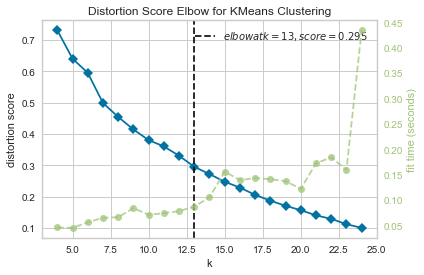

In [91]:
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(4,25))

visualizer.fit(venues_clustering)
visualizer.poof()

So, according to the _elbow method_, the best value for K is 13.
Let's build the model with this value:

In [101]:
# Best K parameter
k_clusters = 13

# Run K-Means clustering algorithm
model = KMeans(n_clusters=k_clusters, random_state=0).fit(venues_clustering)

# Check cluster labels generated for each row in the dataframe
model.labels_[0:10] 

array([12,  0,  9,  5,  3,  0,  0,  0,  7,  0])

Now we have the clusters, we can add them as a new column to the dataframe we had before:

In [98]:
# Add clustering labels
venues_sorted.insert(0, 'Cluster Labels', model.labels_)

venues_merged = codes_selected

# Merge venues_grouped with the DF with the Postal Codes selected
# to add latitude/longitude for each neighborhood group
venues_merged = venues_merged.join(venues_sorted.set_index('Postal Code'), on='PostalCode')

venues_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,12,Pub,Bar,Breakfast Spot,Sandwich Place,Café,Japanese Restaurant,Church,Beach,Bookstore,Business Service
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Pub,Café,Italian Restaurant,Fast Food Restaurant,Yoga Studio,Pizza Place,Spa,Sandwich Place
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,9,Indian Restaurant,Café,Coffee Shop,Burger Joint,Italian Restaurant,Brewery,Pet Store,Fast Food Restaurant,Gym,Sandwich Place
43,M4M,East Toronto,Studio District,43.659526,-79.340923,5,Bakery,Café,Coffee Shop,Bar,Diner,Brewery,Italian Restaurant,Sandwich Place,Pizza Place,Park
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,3,Coffee Shop,Park,Restaurant,Bus Line,Café,Gym / Fitness Center,Bookstore,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


And lastly, we can visualize the resulting clusters:

In [102]:
# Create a Folium map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Set the color scheme for the clusters
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venues_merged['Latitude'], venues_merged['Longitude'], venues_merged['PostalCode'], venues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### f) Analysing the resultant clusters and final conclusions

As the _elbow method_ graphic showed, it is pretty hard to define how many clusters the model should use, as the elbow was not clear enough, and therefore determine the exact caracteristics of each cluster may be a little fuzzy. Anyway, we will try to determine them.

#### Cluster 1:

In [107]:
venues_merged.loc[venues_merged['Cluster Labels'] == 0, venues_merged.columns[[1,2] + list(range(5, venues_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,East Toronto,"The Danforth West, Riverdale",0,Greek Restaurant,Coffee Shop,Pub,Café,Italian Restaurant,Fast Food Restaurant,Yoga Studio,Pizza Place,Spa,Sandwich Place
45,Central Toronto,Davisville North,0,Pizza Place,Coffee Shop,Café,Italian Restaurant,Pharmacy,Dessert Shop,Fast Food Restaurant,Ramen Restaurant,Sporting Goods Shop,Deli / Bodega
46,Central Toronto,North Toronto West,0,Coffee Shop,Sporting Goods Shop,Italian Restaurant,Skating Rink,Café,Diner,Dessert Shop,Flower Shop,Spa,Electronics Store
47,Central Toronto,Davisville,0,Italian Restaurant,Sushi Restaurant,Coffee Shop,Café,Pizza Place,Dessert Shop,Fast Food Restaurant,Restaurant,Sandwich Place,Gym
49,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",0,Coffee Shop,Sushi Restaurant,Thai Restaurant,Italian Restaurant,Gym,Bagel Shop,Pizza Place,Spa,Restaurant,Grocery Store
51,Downtown Toronto,"Cabbagetown, St. James Town",0,Coffee Shop,Café,Restaurant,Pizza Place,Pharmacy,Park,Pub,Indian Restaurant,Gastropub,Beer Store
52,Downtown Toronto,Church and Wellesley,0,Coffee Shop,Japanese Restaurant,Gay Bar,Café,Burger Joint,Sushi Restaurant,Restaurant,Gym,Men's Store,Ramen Restaurant
54,Downtown Toronto,"Ryerson, Garden District",0,Coffee Shop,Clothing Store,Middle Eastern Restaurant,Gastropub,Ramen Restaurant,Café,Tea Room,Department Store,Bookstore,Restaurant
57,Downtown Toronto,Central Bay Street,0,Coffee Shop,Italian Restaurant,Park,Japanese Restaurant,Café,Middle Eastern Restaurant,Ramen Restaurant,Burger Joint,Burrito Place,Plaza
65,Central Toronto,"The Annex, North Midtown, Yorkville",0,Coffee Shop,Café,Pub,Italian Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Sandwich Place,Jewish Restaurant,Tea Room,Burger Joint


**Main characteristics:**  
This cluster of neighborhood groups appears to be eating areas, and mostly you can easily find **Coffee Shops** around those neighborhoods and some thematic restaurants.

#### Cluster 2:

In [109]:
venues_merged.loc[venues_merged['Cluster Labels'] == 1, venues_merged.columns[[1,2] + list(range(5, venues_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,Downtown Toronto,Rosedale,1,Park,Bank,Trail,Playground,Building,Candy Store,Grocery Store,Comic Shop,Design Studio,Ethiopian Restaurant


**Main characteristics:**  
This cluster only has one neighborhood: Rosedale. It seems to be a purely urban area, and this follows up with the fact that this neighborhood corresponds to the Downtown of the city, which in many cities it's the economic metropolis.

#### Cluster 3:

In [110]:
venues_merged.loc[venues_merged['Cluster Labels'] == 2, venues_merged.columns[[1,2] + list(range(5, venues_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
53,Downtown Toronto,"Harbourfront, Regent Park",2,Coffee Shop,Bakery,Café,Italian Restaurant,Park,Theater,Restaurant,Pub,Breakfast Spot,Mexican Restaurant
55,Downtown Toronto,St. James Town,2,Coffee Shop,Café,Restaurant,Bakery,Hotel,Gastropub,American Restaurant,Breakfast Spot,Cosmetics Shop,Italian Restaurant
56,Downtown Toronto,Berczy Park,2,Coffee Shop,Café,Hotel,Restaurant,Beer Bar,Japanese Restaurant,Cocktail Bar,Bakery,Park,Farmers Market
58,Downtown Toronto,"Adelaide, King, Richmond",2,Café,Coffee Shop,Steakhouse,Hotel,Gym,American Restaurant,Theater,Pizza Place,Sushi Restaurant,Bar
59,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",2,Coffee Shop,Hotel,Italian Restaurant,Café,Aquarium,Scenic Lookout,Restaurant,Brewery,Park,Baseball Stadium
60,Downtown Toronto,"Design Exchange, Toronto Dominion Centre",2,Café,Coffee Shop,Hotel,Restaurant,Gym,Bakery,Bar,Italian Restaurant,American Restaurant,Steakhouse
61,Downtown Toronto,"Commerce Court, Victoria Hotel",2,Coffee Shop,Hotel,Café,Restaurant,American Restaurant,Steakhouse,Seafood Restaurant,Japanese Restaurant,Gym,Gastropub
69,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,2,Coffee Shop,Café,Beer Bar,Japanese Restaurant,Restaurant,Breakfast Spot,Hotel,Bakery,Cocktail Bar,Seafood Restaurant
70,Downtown Toronto,"First Canadian Place, Underground city",2,Coffee Shop,Café,Hotel,Steakhouse,Restaurant,Gastropub,American Restaurant,Bar,Deli / Bodega,Bakery


**Main characteristics:**  
This cluster is very similar to the first one, but with the difference that in these neighborhoods groups, you can purely find **Coffee Shops** and anything else pretty rarely. It makes sense because these neighborhoods correspond to the Downtown borough, which use to be full of business men.

#### Cluster 4:

In [111]:
venues_merged.loc[venues_merged['Cluster Labels'] == 3, venues_merged.columns[[1,2] + list(range(5, venues_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Central Toronto,Lawrence Park,3,Coffee Shop,Park,Restaurant,Bus Line,Café,Gym / Fitness Center,Bookstore,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


**Main characteristics:**  
This cluster only has one neighborhood again: Lawrence Park. It seems to be a urban area but with a few more diverse businesses, compared to the other clusters' neighborhoods where Coffee Shops predominate.

#### Cluster 5:

In [112]:
venues_merged.loc[venues_merged['Cluster Labels'] == 4, venues_merged.columns[[1,2] + list(range(5, venues_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Central Toronto,Roselawn,4,Playground,Garden,Pet Store,Home Service,Dog Run,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar


**Main characteristics:**  
This cluster only has one neighborhood again: Roselawn. It seems to be a more residential neighborhood. A quiet place to live, with families habiting this area.

#### Cluster 6:

In [113]:
venues_merged.loc[venues_merged['Cluster Labels'] == 5, venues_merged.columns[[1,2] + list(range(5, venues_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,East Toronto,Studio District,5,Bakery,Café,Coffee Shop,Bar,Diner,Brewery,Italian Restaurant,Sandwich Place,Pizza Place,Park
66,Downtown Toronto,"Harbord, University of Toronto",5,Café,Restaurant,Vegetarian / Vegan Restaurant,Bakery,Coffee Shop,Pub,Pizza Place,Bookstore,Bubble Tea Shop,Comic Shop
67,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",5,Café,Vegetarian / Vegan Restaurant,Bar,Mexican Restaurant,Vietnamese Restaurant,Bakery,Coffee Shop,Dessert Shop,Chinese Restaurant,Comfort Food Restaurant
77,West Toronto,"Little Portugal, Trinity",5,Bar,Café,Coffee Shop,Restaurant,Bakery,Cocktail Bar,Italian Restaurant,Asian Restaurant,Boutique,Theater
78,West Toronto,"Brockton, Exhibition Place, Parkdale Village",5,Coffee Shop,Arts & Crafts Store,Restaurant,Café,Bakery,Bar,Furniture / Home Store,Plaza,Caribbean Restaurant,Thrift / Vintage Store
82,West Toronto,"High Park, The Junction South",5,Café,Bar,Italian Restaurant,Mexican Restaurant,Park,Coffee Shop,Thai Restaurant,Deli / Bodega,Arts & Crafts Store,Antique Shop
83,West Toronto,"Parkdale, Roncesvalles",5,Restaurant,Bar,Café,Coffee Shop,Breakfast Spot,Pizza Place,Sushi Restaurant,Thai Restaurant,Dog Run,Pub


**Main characteristics:**  
This cluster has a variety of neighborhood groups, which main characteristic is Coffee Shops again, but with a large quantity of restaurants and food related businesses. It may be a small commercial area dedicated to gastronomy.

#### Cluster 7:

In [114]:
venues_merged.loc[venues_merged['Cluster Labels'] == 6, venues_merged.columns[[1,2] + list(range(5, venues_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
68,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo...",6,Harbor / Marina,Airport Terminal,Boat or Ferry,Coffee Shop,Sculpture Garden,Airport Lounge,Airport Service,Plane,Bar,Music Venue


**Main characteristics:**  
This cluster only has one neighborhood group. Those neighborhoods seem to be coast and airport areas, harboring mainly airports and boat ports.

#### Cluster 8:

In [115]:
venues_merged.loc[venues_merged['Cluster Labels'] == 7, venues_merged.columns[[1,2] + list(range(5, venues_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,Central Toronto,"Moore Park, Summerhill East",7,Park,Grocery Store,Japanese Restaurant,Café,Thai Restaurant,Bank,Candy Store,Sandwich Place,Sushi Restaurant,Tennis Court


**Main characteristics:**  
This cluster only has one neighborhood group, consisting of two neighborhoods. Those seem to be a food-related business areas, with a large quantity of Asian-food restaurants.

#### Cluster 9:

In [116]:
venues_merged.loc[venues_merged['Cluster Labels'] == 8, venues_merged.columns[[1,2] + list(range(5, venues_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
64,Central Toronto,"Forest Hill North, Forest Hill West",8,Italian Restaurant,Coffee Shop,Bakery,Bank,Japanese Restaurant,Deli / Bodega,Café,Gastropub,Trail,Park


**Main characteristics:**  
This cluster only has one neighborhood group with two neighborhoods: Forest Hill North and West. Those seems to be common urban areas with a fuzzy diversity of non-related businesses.

#### Cluster 10:

In [117]:
venues_merged.loc[venues_merged['Cluster Labels'] == 9, venues_merged.columns[[1,2] + list(range(5, venues_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
42,East Toronto,"The Beaches West, India Bazaar",9,Indian Restaurant,Café,Coffee Shop,Burger Joint,Italian Restaurant,Brewery,Pet Store,Fast Food Restaurant,Gym,Sandwich Place


**Main characteristics:**  
This cluster only has one neighborhood group with two neighborhoods: The Beaches West and India Bazaar. The main characteristic of these areas seems to be that the most common venue are Indian restaurants, and the rest are also food-related businesses. 

#### Cluster 11:

In [118]:
venues_merged.loc[venues_merged['Cluster Labels'] == 10, venues_merged.columns[[1,2] + list(range(5, venues_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
75,Downtown Toronto,Christie,10,Korean Restaurant,Grocery Store,Coffee Shop,Convenience Store,Indian Restaurant,Pizza Place,Diner,Café,Park,Japanese Restaurant


**Main characteristics:**  
This cluster only has one neighborhood: Christie. The main characteristic is the abundance of Korean and other Asian restaurants. This cluster maybe could be merged with others where Asian food restaurants are abundant.

#### Cluster 12:

In [119]:
venues_merged.loc[venues_merged['Cluster Labels'] == 11, venues_merged.columns[[1,2] + list(range(5, venues_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
76,West Toronto,"Dovercourt Village, Dufferin",11,Coffee Shop,Park,Bakery,Pharmacy,Portuguese Restaurant,Café,Supermarket,Bar,Gym,Smoke Shop


**Main characteristics:**  
This cluster only has one neighborhood group with two neighborhoods: Dovercourt Village and Dufferin. It looks like the cluster corresponds to a urban area but with a variety of different kind of non-related businesses. Again, this cluster maybe could be merged with other diverse businesses clusters.

#### Cluster 13:

In [120]:
venues_merged.loc[venues_merged['Cluster Labels'] == 12, venues_merged.columns[[1,2] + list(range(5, venues_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,East Toronto,The Beaches,12,Pub,Bar,Breakfast Spot,Sandwich Place,Café,Japanese Restaurant,Church,Beach,Bookstore,Business Service


**Main characteristics:**  
This cluster only has one neighborhood: The Beaches. It seems to be a common area for drinking businesses, with a great quantity of Pubs and Bars. Looking in the map, it is next to a coastal area, as the neighborhood name suggests.

## Final thoughts

We have analysed deeply the different kind of neighborhood groups divided by individual distinct Postal Codes and through the data, we are now able to tell which are great areas for a diverse number of businesses types (especially Coffee Shops hehe).

We are also able to tell which neighborhood groups hold a lot of simmilarities between them.

In the future, we may analyse even deeper, by obtaining information about each neighborhood, or even other neighborhood groups ignored in this analysis.

Thank you for reading.